In [1]:
############
# imports ##
############

from matplotlib import pyplot as py
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from __future__ import division, print_function
from functools import partial, reduce
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore
import fitpack
import interface
import obslib.sidis.reader
from qcdlib.auxiliary import AUX
from tools.config import conf
import copy
%matplotlib inline

In [2]:
#####################
# reading the data ##
#####################
def get_data():
    # Merge all of the data tables
    return reduce(partial(pd.DataFrame.merge, how="outer"), map(pd.DataFrame, conf["sidis tabs"].values()))

In [3]:
input_file = "../inputs/upol_hermes_no_filters.py"

CUTMIN = 0.99
CUTMAX = 5.28

filterstr = "dy>"
#filterstr = "yh_minus_yp>"

The interface.py allows to get configuration file from the file that we read.

In [4]:
interface.gen_config(input_file)  # Read file

conf["datasets"]["sidis"]["filters"][0] = filterstr + str(CUTMIN)  # Apply filter with min cut

conf["aux"] = AUX()
conf["sidis tabs"] = obslib.sidis.reader.READER().load_data_sets("sidis")
#conf['sidis stfuncs'] = obslib.sidis.stfuncs.STFUNCS()

data = get_data().sort_values("dy")

loading sidis data sets 1007

In [5]:
print(", ".join(sorted(data.columns)))

Ebeam, F2, Q2, R, R0, R1, R2, W2, col, dy, hadron, i, lnR, obs, pT, qT, stat_u, systabs_u, systole, systrel, target, value, x, xn, y, yf, yh, yi, yp, z, zn


In [6]:
dat = data.query("R0 <= 1 and R1 <= 1 and R2 <= 1")


In [7]:
def custom_label(label):
    if label =="Q2":
        label="$Q^2$"
    if label =="qT":
        label="$q_T$"
    if label =="qT":
        label="$q_T$"
    if label =="W2":
        label="$W^2\; (GeV^2)$"
    if label =="qToverQ":
        label="$q_T/Q$"
    if label =="qToverQ2":
        label="$q_T^2/Q^2$"
    if label =="dy":
        label="$y_p-y_h$"
    if label =="yh_minus_yp":
        label="$y_h-y_p$"
    if label =="yi":
        label="$y_i$"
    if label =="yf":
        label="$y_f$"
    if label =="yh":
        label="$y_h$"
    if label =="yp":
        label="$y_p$"
    if label =="yi_minus_yp":
        label="$|y_i - y_p|$"
    if label =="yf_minus_yh":
        label="$|y_f - y_h|$"
    if label =="yi_minus_yp_over_yp":
        label="$|(y_i - y_p)/yp|$"
    if label =="yf_minus_yh_over_yh":
        label="$|(y_f - y_h)/yh|$"
    if label =="R":
        label="$|R|$"    
    if label =="lnR":
        label="$ln(|R|)$"    
    if label =="R2":
        label="$R_2$"    
    if label =="R1":
        label="$R_1$"    
    if label =="R0":
        label="$R_0$"    

    return label

def color_plot(data,vert_lab, hor_lab, cmap="plasma", alpha=1.0):
    vert = data[vert_lab].values
    hor = data[hor_lab].values
    dat["QCUT"] = (dat["qT"])**2/ (dat["Q2"])
    data_q = dat["QCUT"]
    #colors = (data_q - min(data_q)) / (max(data_q) - min(data_q))  # XXX
    
    color_percentiles = partial(percentileofscore, data_q)
    colors = data_q.apply(color_percentiles)
    
    fig, ax = plt.subplots()
    ax.set_ylabel(custom_label(vert_lab))
    ax.set_xlabel(custom_label(hor_lab))
    ax.set_xticks(np.arange(0,1.1,.1))
    ax.set_yscale('log')
    ax.scatter(hor, vert, c=colors, cmap=plt.get_cmap(cmap), alpha=alpha)

    #heatmap = ax.pcolor(data_q, cmap=plt.get_cmap(cmap)) # heatmap 
    #plt.colorbar(heatmap)

    #fig.tight_layout()
    
    return fig, ax, vert, hor


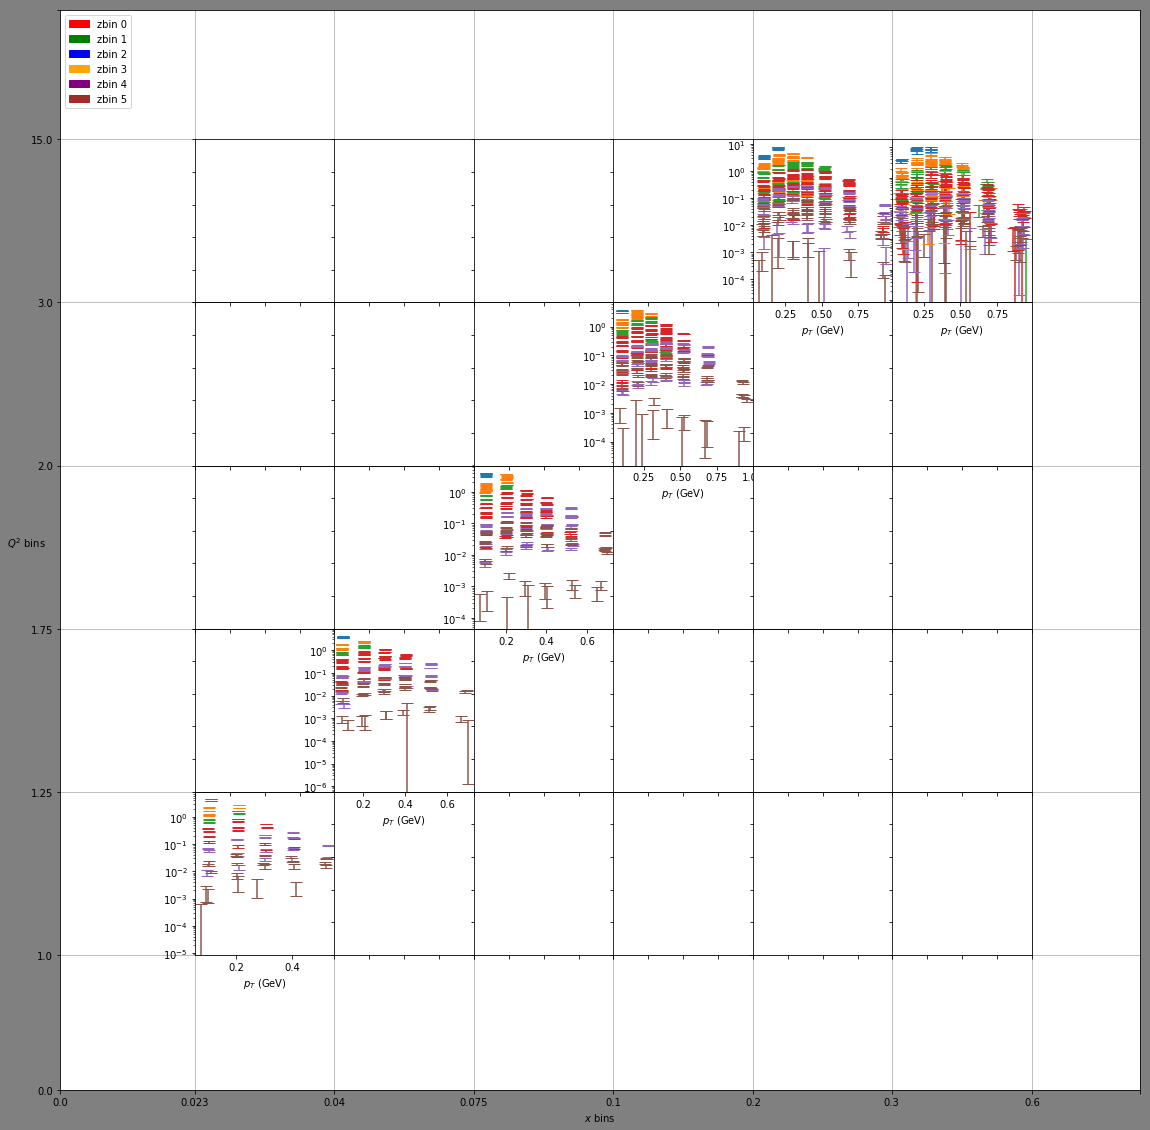

In [42]:
# data bin edeges
xBin=np.array([0.023,0.04,0.055,0.075,0.1,0.14,0.2,0.3,0.4,0.6]) # Tick marks figure x-axis
Q2Bin=np.array([1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 5.0, 15.0]) # Tick marks figure y-axis
zBin= np.array([0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.1]) # catagories for z to be ploted indiviualy in each subplot
# binning data
dat['xBin'] = pd.cut(dat['x'], xBin,labels = False, retbins=0)
dat['Q2Bin'] = pd.cut(dat['Q2'], Q2Bin,labels = False, retbins=0)
dat['zBin'] = pd.cut(dat['z'], zBin,labels = False, retbins=0)

# bins for x and y that have non-empty intersection
pTdatmod=[0,2,3,5,6,8] # xBins that overlap Q2Bins
valuedatmod=[0,2,3,6,8] # Q2bins that overlap xBins

# initialize the figure
fig1=py.figure(figsize=(15, 15),facecolor="gray") # figsize; wxh in inches
globalGrid=gridspec.GridSpec(1, 1, wspace=0.0, hspace=0.0) # plot for subplot matrix as 1x1 matrix
innerGrid=gridspec.GridSpecFromSubplotSpec(5, 6, subplot_spec=globalGrid[0], wspace=0.0, hspace=0.0) # 5x6 subplot grid 

# figure properties:
ax=fig1.add_axes([0,0,1,1]) # axas for subplot matrix as percent of hole
ax.yaxis.set_ticks([0,1.25,2.76,4.27,5.78,7.29,8.8,10])
ax.xaxis.set_ticks([0,1.25,2.54,3.83,5.12,6.42,7.7,9,10 ])
#xticklabels = np.array(['','[0,0.023)','[0.04,0.055)','[0.055,0.075)','[0.1,0.14)',
#                            '[0.14,0.1)','[0.4,0.6)'])
#yticklabels = np.array(['','[0,1.0)','[1.25,1.5)','[1.5,1.75)','[2.25,2.5)','[5.0,15.0)'])
xticklabels = np.array([0,0.023,0.04,0.075,0.1,0.2,0.3,0.6]) 
yticklabels = np.array([0,1.0, 1.25, 1.75, 2.0, 3.0, 15.0])
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.set_xlabel(r"$x$ bins") # xy-lables
ax.set_ylabel(r"$Q^2$ bins",rotation="horizontal")
ax.grid() # grid on

# subplot axis proerties (unused)
Zcolor=["red","green","blue","orange","purple","brown"]
Zmark=["o","o","o","o"]

# Set legend
Zpatch1 = mpatches.Patch(color=Zcolor[0], label='zbin 0')
Zpatch2 = mpatches.Patch(color=Zcolor[1], label='zbin 1')
Zpatch3 = mpatches.Patch(color=Zcolor[2], label='zbin 2')
Zpatch4 = mpatches.Patch(color=Zcolor[3], label='zbin 3')
Zpatch5 = mpatches.Patch(color=Zcolor[4], label='zbin 4')
Zpatch6 = mpatches.Patch(color=Zcolor[5], label='zbin 5')
ax.legend(handles=[Zpatch1,Zpatch2,Zpatch3,Zpatch4,Zpatch5,Zpatch6],loc='upper left')

num = 0
for f,F in zip(range(len(pTdatmod)),pTdatmod):       
    for j,J in zip(range(len(valuedatmod)),valuedatmod):
        if j == 4:
            k = int(f) # kth possition for subplot on innerGrid matrix
            maskX = dat['xBin'].isin([F]) # retruns boolean for all Jth xBin in dat  
            maskY = dat['Q2Bin'].isin([J]) # retruns boolean for all Fth Q2Bin in dat
        elif j == 3:
            k = 6 + int(f)
            maskX = dat['xBin'].isin([F]) 
            maskY = dat['Q2Bin'].isin([J])
        elif j == 2:
            k = 12 + int(f)
            maskX = dat['xBin'].isin([F]) 
            maskY = dat['Q2Bin'].isin([J])
        elif j == 1:
            k = 18 + int(f)
            maskX = dat['xBin'].isin([F]) 
            maskY = dat['Q2Bin'].isin([J])
        elif j == 0:
            k = 24 + int(f)
            maskX = dat['xBin'].isin([F]) 
            maskY = dat['Q2Bin'].isin([J])
        ax = fig1.add_subplot(innerGrid[k]) # add subplot in innerGrid
        xydat = dat[maskX & maskY] # subset of data for Jth xBin and Fth Q2Bin
        for z in range(len(zBin)-1): 
            maskZ = xydat["zBin"].isin([z])
            databin = xydat[maskZ]
            
            if databin.empty:
                num += 1
                ax.set_yticklabels('')
                ax.set_xticklabels('')
                pass
            else:
#                print('xbin = ' + str(f))
#                print('ybin = ' + str(j))
#                print('k = ' + str(k))
#                print(databin)
                ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],capsize=6,linestyle="")
                if k == 5:
                    ax.set_xlabel(r"$p_T$ (GeV)")
                    ax.set_yscale('log')
                    ax.set_yticklabels("")  
                else:
                    ax.set_yscale("log") 
                    ax.set_xlabel(r"$p_T$ (GeV)")

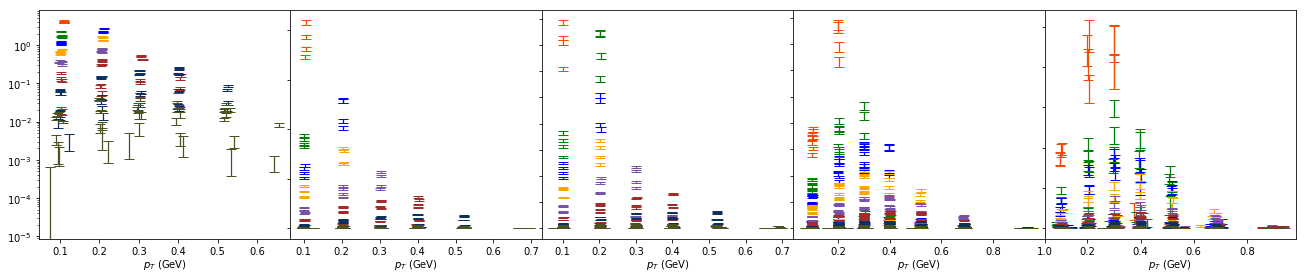

In [41]:
dat["delta"] = np.sqrt(dat["stat_u"]**2.0) # measurment error
dat["qT"] = dat["pT"]/dat["z"] # transverse momentum **NOTE** not used in plot
dat["qT2"] = dat["qT"]**2 # square of transverse momentum **NOTE** not used in plot

##################
## Binning data ##
##################
# data bin edeges

xBin=np.array([0.023,0.047,0.075,0.12,0.35,0.6]) # Bins for x used to plot Pt
Q2Bin=np.array([1.0,10]) # **NOTE** includes all Q2 data, therefore all value data is plotted vs. Pt
zBin= np.array([0.1, 0.2,0.25,0.3, 0.375, 0.475, 0.6, 0.8, 1.1]) # catagories for z to be ploted indiviualy in each subplot
Phperp = np.array([ 0.0, 0.15, 0.25, 0.35, 0.45, 0.6, 0.8, 1.2]) 
# binning data
dat['xBin'] = pd.cut(dat['x'], xBin,labels = False, retbins=0)
dat['Q2Bin'] = pd.cut(dat['Q2'], Q2Bin,labels = False, retbins=0)
dat['zBin'] = pd.cut(dat['z'], zBin,labels = False, retbins=0)

# bins for x and y that have non-empty intersection
pTdatmod=[0,1,2,3,4] # xBins that overlap Q2Bins
valuedatmod=[0] # Q2bins that overlap xBins

###############
# HermesPlot ##
###############  Reduced matix 
#initialize the figure
fig1=py.figure(figsize=(18, 4),facecolor="white") # figsize; wxh in inche
globalGrid=gridspec.GridSpec(1, 1,left=0.03,right=1,top=.91,bottom=.115, wspace=0.0, hspace=0.0) # plot for subplot matrix as 1x1 matrix
innerGrid=gridspec.GridSpecFromSubplotSpec(1,5 , subplot_spec=globalGrid[0], wspace=0.0, hspace=0.0) # 5x6 subplot grid 

# figure properties:
#ax=fig1.add_axes([0,0,1,1]) # axas for subplot matrix as percent of hole
##ax.yaxis.set_ticks([0,1.25,2.76,4.27,5.78,7.29,8.8,10])
#ax.xaxis.set_ticks([0,1.25,2.8,4.35,5.9,7.45,9,10 ])
#xticklabels = np.array([0,0.023,0.047,0.075,0.12,0.35,0.6]) 

ax.set_yticklabels("")
ax.set_xticklabels(xticklabels)
ax.set_xlabel(r"$x$ bins") # xy-lables
ax.set_ylabel(r"$Q^2$",rotation="horizontal",labelpad = 15)
#ax.grid() # grid currently off

# subplot axis proerties (unused)
Zcolor=['#F74902',"green","blue",'orange',"#7851a9","brown",'#093162','#4b5320']
Zmark=["o","o","o","o"]

# Set legend
Zpatch1 = mpatches.Patch(color=Zcolor[0], label='0.1<z<0.2')
Zpatch2 = mpatches.Patch(color=Zcolor[1], label='0.2<z<0.25')
Zpatch3 = mpatches.Patch(color=Zcolor[2], label='0.25<z<0.3')
Zpatch4 = mpatches.Patch(color=Zcolor[3], label='0.3<z<0.375')
Zpatch5 = mpatches.Patch(color=Zcolor[4], label='0.375<z<0.475')
Zpatch6 = mpatches.Patch(color=Zcolor[5], label='0.475<z<0.6')
Zpatch7 = mpatches.Patch(color=Zcolor[6], label='0.6<z<0.8')
Zpatch8 = mpatches.Patch(color=Zcolor[7], label='0.8<z<1.1')

#ax.legend(handles=[Zpatch1,Zpatch2,Zpatch3,Zpatch4,Zpatch5,Zpatch6,Zpatch7,Zpatch8],
#          bbox_to_anchor=(0, 1),
#          mode='expand'
#          )
          #loc='best')
#borderaxespad=10
          
ax.legend(handles=[Zpatch1,Zpatch2,Zpatch3,Zpatch4,Zpatch5,Zpatch6,Zpatch7,Zpatch8],
          loc='upper center',
          ncol=8,prop={'size': 9}
          )
          #loc='best')
#borderaxespad=10

for f,F in zip(range(len(pTdatmod)),pTdatmod):       
    for j,J in zip(range(len(valuedatmod)),valuedatmod):
        
        k = int(f) # kth possition for subplot on innerGrid matrix
        maskX = dat['xBin'].isin([F]) # returns boolean for all Jth xBin in dat  
        maskY = dat['Q2Bin'].isin([J]) # returns boolean for all Fth Q2Bin in dat
       
        ax = fig1.add_subplot(innerGrid[k]) # add subplot in innerGrid
        xydat = dat[maskX & maskY] # subset of data for Jth xBin and Fth Q2Bin
        for z in range(len(zBin)-1): 
            maskZ = xydat["zBin"].isin([z])
            databin = xydat[maskZ]
            
            if f != 0:
                ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],capsize=5,linestyle="",color = Zcolor[z],elinewidth=1.25)
                ax.set_xlabel(r"$p_T$ (GeV)",labelpad=1)
                ax.set_yticklabels('')
               
            else:
                ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],capsize=5,linestyle="", color = Zcolor[z],elinewidth=1.25)
                
                ax.set_xlabel(r"$p_T$ (GeV)",labelpad=1)
                ax.set_yscale('log')

plt.show()             
#pp = PdfPages('mod1000zk.pdf')
#pp.savefig(fig1)
#pp.close()                             

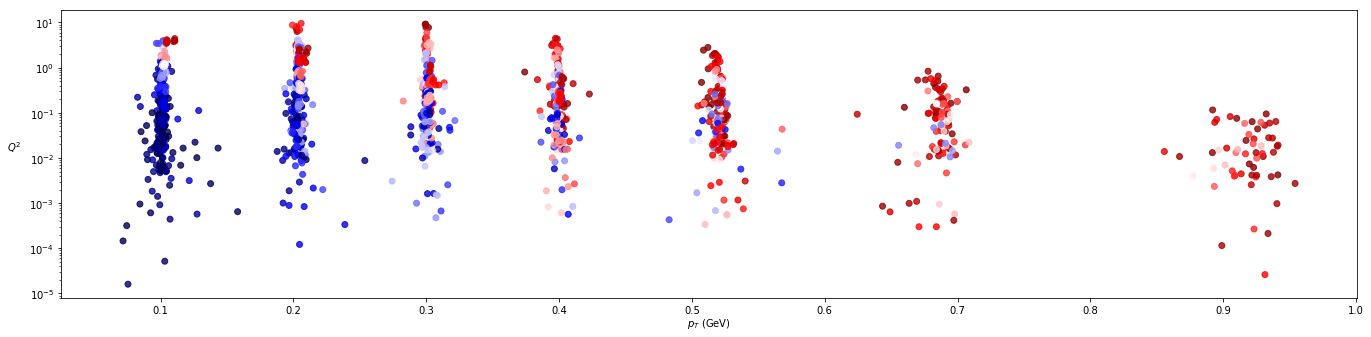

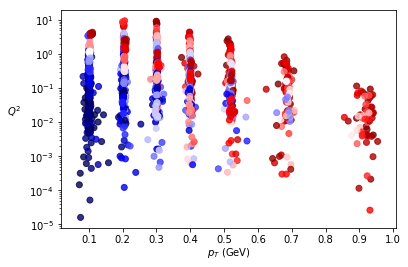

In [9]:
######################
# Calculated values ##
######################

dat["QCUT"] = (dat["qT"])**2/ (dat["Q2"])
data_q = dat["QCUT"]

##############
#HERMES Plots#
##############

# Plots using a layout similar to old plot spring 2018
fig1=py.figure(figsize=(18, 4),facecolor="white") # figsize; wxh in inche
#fig, ax = plt.subplots()
ax=fig1.add_axes([0,0,1,1])

ax.set_ylabel(r"$Q^2$",rotation="horizontal",labelpad = 15)
ax.set_xlabel(r"$p_T$ (GeV)",labelpad=1)
ax.set_xticks(np.arange(0,1.1,.1))
ax.set_yscale('log')
#ax.set_xscale('log')

color_percentiles = partial(percentileofscore, data_q)
colors = data_q.apply(color_percentiles)
ax.scatter(dat['pT'],dat['value'], c=colors, cmap=plt.get_cmap('seismic'), alpha=0.8)        
#ax.legend(['R0','R1','R2'])
plt.show()

# Plots using a layout similar to collinearity repo HERMES_data_analysis.ipynb
fig2, ax = plt.subplots()


ax.set_ylabel(r"$Q^2$",rotation="horizontal",labelpad = 15)
ax.set_xlabel(r"$p_T$ (GeV)",labelpad=1)
ax.set_xticks(np.arange(0,1.1,.1))
ax.set_yscale('log')
#ax.set_xscale('log')

color_percentiles = partial(percentileofscore, data_q)
colors = data_q.apply(color_percentiles)
ax.scatter(dat['pT'],dat['value'], c=colors, cmap=plt.get_cmap('seismic'), alpha=0.8)        
#ax.legend(['R0','R1','R2'])
plt.show()

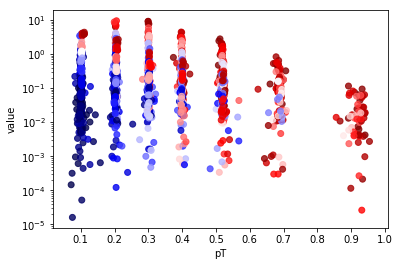

In [10]:
# Hermes plot using color_plot function found in HERMES_data_analysis.ipynb

fig, ax, vert, hor = color_plot(dat,"value", "pT",cmap="seismic", alpha=0.8)

plt.show()